In [1]:
import pandas as pd
import nibabel as nib
from pathlib import Path
from utils.features import FEATURES,df_to_series
from utils.parcellation import parcellation_labels
from itertools import chain

In [2]:
mother_dir = Path("/media/groot/Yalla/media/MRI/derivatives")
subjects = sorted(set([subj.name for subj in mother_dir.glob("*/sub-*") if subj.is_dir()]))
modalities = list(chain(FEATURES.keys()))
parameters = list(chain(*FEATURES.values()))

n_indices = parcellation_labels.shape[0] * len(parameters)

index_df = pd.DataFrame(columns=["Hemisphere","Name","Modality","Feature"])
for modality,parameters in FEATURES.items():
    for param in parameters:
        tmp = pd.DataFrame(columns=index_df.columns,index=range(parcellation_labels.shape[0]))
        tmp["Hemisphere"] = parcellation_labels.Hemi.values
        tmp["Name"] = parcellation_labels.ROIname.values
        tmp["Modality"] = modality
        tmp["Feature"] = param
        index_df = pd.concat([index_df,tmp],ignore_index=True)


mindex = pd.MultiIndex.from_frame(index_df,names=["Hemisphere","Name","Modality","Features"])
df = pd.DataFrame(columns=mindex,index=subjects)
df.columns = df.columns.sort_values(ascending=False)

In [3]:
for subj in df.index:
    for modality in modalities:
        if modality == "DWI":
            regions_fname = mother_dir / "dwiprep" / subj / "ses-1" / "tensors_parameters" / "coreg_FS" / "Brainnetome_parcels.csv"
        elif modality == "SMRI":
            subj_dir = mother_dir / "fmriprep" / subj
            sessions = [ses.name for ses in subj_dir.glob("ses-*")]
            if len(sessions) > 1:
                anat_dir = subj_dir / "anat"
            elif len(sessions) == 1:
                anat_dir = subj_dir / sessions[0] / "anat"
            else:
                continue
            regions_fname =  anat_dir / "Brainnetome_parcels.csv"
        if not regions_fname.exists():
            continue
        try:
            tmp_df = pd.read_csv(regions_fname,index_col=0)
            

            df.loc[subj,(slice(None),slice(None),modality,slice(None))] = df_to_series(tmp_df,mindex,modality,FEATURES.copy())
        except KeyError:
            continue
    # break


In [4]:
df = df.dropna(how="all")

In [ ]:
df

<AxesSubplot:xlabel='value', ylabel='Density'>

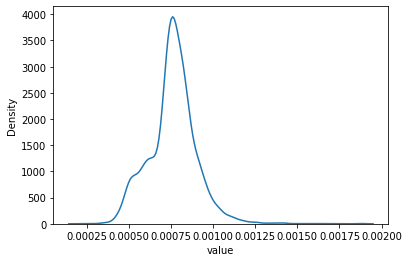

In [43]:
import seaborn as sns
t = df.melt()
t = t[t["Features"] == "MD"]
t["value"] = t["value"].astype(float)
sns.kdeplot(x="value",data=t)